In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm

###################################################################################################
# Please provide the following information.
firm = "HTZ"  # The firm ticker symbol
start_date_past_data = "2021-04-22"  # To compute volatility, we will use past data starting from this date
end_date_past_data = "2025-05-22"    # Different historical periods will result in different volatility values!
#######################################################################################################

# Load historical data
symbol = firm
data = yf.download(symbol, start=start_date_past_data, end=end_date_past_data)

# Check if data is empty
if data.empty:
    raise ValueError("No data was loaded. Please check the symbol or your internet connection.")

# Check if 'Close' column exists
if 'Close' not in data.columns:
    raise KeyError("The 'Close' column was not found in the data.")

# Extract closing prices
prices = data["Close"]

# Get stock object to retrieve current price
stock = yf.Ticker(symbol)
S0 = stock.info['currentPrice']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed



📊 GBM Parameters:
                 Parameter   Value
Annual mean log return μ = -0.3777
     Annual volatility σ =  0.7563


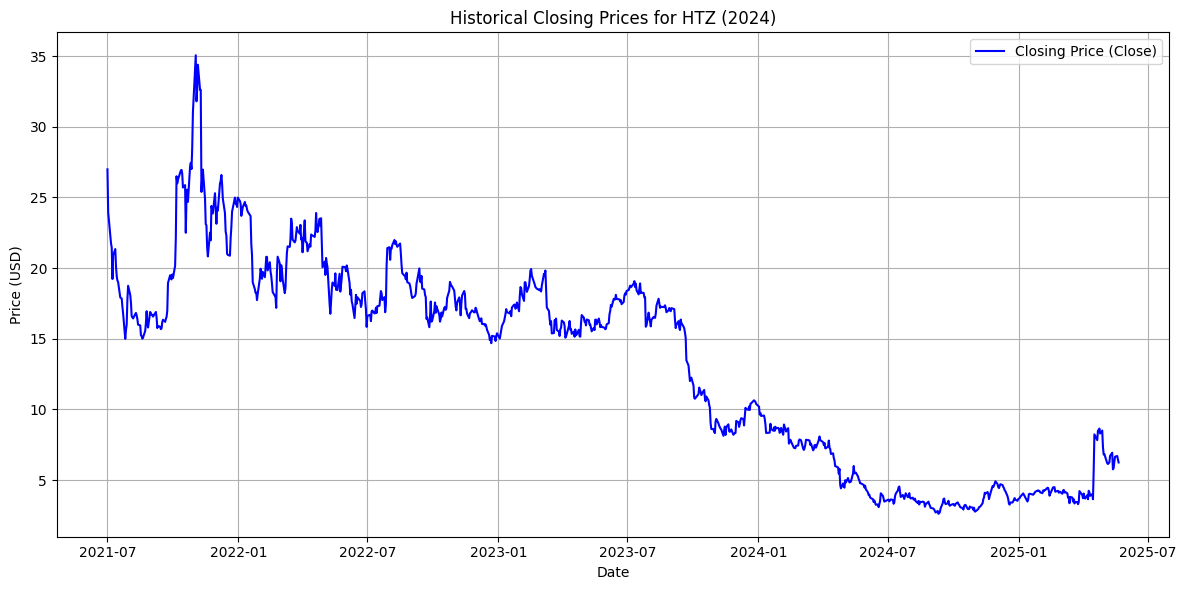

Option price via Monte Carlo: 2.8069171013080583


In [3]:
T = 240 / 360  # Expiration date in years
r = 0.0  # Risk-free interest rate

#############################################################################################
# Define the payoff function below
def payoff_func(x):
    return np.maximum(np.maximum(x - 5, 0), np.maximum(3 - x, 0))
#############################################################################################


def monte_carlo_option_pricer(payoff_func, S0, T, r, sigma, n_sim=10000):
    """
    Calculates the price of an option with payoff f(S_T) using Monte Carlo simulation.

    Args:
        payoff_func: function that takes ST and returns payoff (e.g., def f(ST): return ...)
        S0: initial stock price
        T: time to maturity (in years)
        r: risk-free interest rate (continuous compounding)
        sigma: volatility
        n_sim: number of simulations

    Returns:
        price: estimated option price
        std_error: standard error of the estimate
    """
    np.random.seed(42)  # For reproducibility
    Z = np.random.normal(size=n_sim)

    # GBM model: S_T = S0 * exp( (r - 0.5*sigma^2)*T + sigma*sqrt(T)*Z )
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

    # Calculate payoffs for each simulation
    payoffs = payoff_func(ST)

    # Discount the payoffs to present value
    discounted_payoffs = np.exp(-r * T) * payoffs

    # Estimate price and standard error
    price = np.mean(discounted_payoffs)
    std_error = np.std(discounted_payoffs) / np.sqrt(n_sim)

    return price, std_error




# Compute logarithmic returns
log_returns = np.log(prices / prices.shift(1)).dropna()

# Estimate parameters for GBM model
mu = log_returns.mean()  # Mean daily log return
sigma = log_returns.std()  # Daily volatility

# Convert to annualized values
annual_mu = mu * 252
annual_sigma = sigma * np.sqrt(252)

# Ensure they are floats
annual_mu = annual_mu.item()  # or float(annual_mu)
annual_sigma = annual_sigma.item()  # or float(annual_sigma)


# Create a table with GBM parameters
parameters = {
    "Parameter": ["Annual mean log return μ =", "Annual volatility σ ="],
    "Value": [f"{annual_mu:.4f}", f"{annual_sigma:.4f}"]
}

df_params = pd.DataFrame(parameters)

# Print the parameter table
print("\n📊 GBM Parameters:")
print(df_params.to_string(index=False))

# --- Plotting section ---
plt.figure(figsize=(12, 6))
plt.plot(prices.index, prices.values, label='Closing Price (Close)', color='blue')
plt.title(f"Historical Closing Prices for {symbol} (2024)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Assigning parameters to variables
m = annual_mu
sigma = annual_sigma

# Call Monte Carlo pricer
price, error = monte_carlo_option_pricer(payoff_func, S0, T, r, sigma, n_sim=10000)


# Print results
print('Option price via Monte Carlo:', price)
